In [7]:
# ==========================================
# 1. 환경 설정 및 라이브러리 임포트
# ==========================================
import sys
import os
import pickle
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 드라이브 마운트
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 경로 설정 (본인 경로에 맞게 수정)
PROJECT_PATH = '/content/drive/MyDrive/DL_Project'
os.chdir(PROJECT_PATH)
sys.path.append(PROJECT_PATH)

try:
    from common.np import *
    from common.time_layers import TimeEmbedding, TimeLSTM, TimeDropout
    from common.layers import Affine, SoftmaxWithLoss, Sigmoid, Dropout
    from common.optimizer import Adam
    from utils import extract_utterances
    print("✅ 라이브러리 로드 성공.")
except ImportError as e:
    print(f"❌ 라이브러리 로드 실패: {e}")

# 시각화 설정
plt.style.use('seaborn-v0_8')

# ==========================================
# 2. 데이터 전처리 및 로더
# ==========================================
def load_vocab(train_csv, max_vocab=4000):
    df = pd.read_csv(train_csv)
    words = []
    print("⏳ Vocab 생성 중...")
    for _, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            text = " ".join([u.clean_text for u in utts]).lower()
            words.extend(text.split())
        except: continue
    counter = Counter(words)
    most_common = counter.most_common(max_vocab)
    vocab = {'<pad>': 0, '<unk>': 1}
    for i, (w, _) in enumerate(most_common):
        vocab[w] = i + 2
    print(f"✅ Vocab 크기: {len(vocab)}")
    return vocab

def load_data(csv_path, vocab, max_len=400):
    df = pd.read_csv(csv_path)
    x_data, t_data = [], []
    label_map = {'TD': 0, 'SLI': 1}
    print(f"📂 데이터 로딩: {csv_path}")
    for _, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            if not utts: continue
            text = " ".join([u.clean_text for u in utts]).lower()
            tokens = text.split()
            ids = [vocab.get(w, vocab['<unk>']) for w in tokens]

            # 길이 제한 (Truncation)
            if len(ids) > max_len:
                ids = ids[:max_len]

            # 패딩 (Padding)
            padded_ids = np.zeros(max_len, dtype=int)
            length = min(len(ids), max_len)
            padded_ids[:length] = ids[:length]

            x_data.append(padded_ids)
            t_data.append(label_map[row['group']])
        except: pass
    return np.array(x_data), np.array(t_data)

# ==========================================
# 3. 모델 정의 (Bi-LSTM + MLP)
# ==========================================
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1, Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        xs_reverse = xs[:, ::-1, :]
        o2 = self.backward_lstm.forward(xs_reverse)
        o2 = o2[:, ::-1, :]
        return np.concatenate((o1, o2), axis=2)

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]
        dxs1 = self.forward_lstm.backward(do1)
        do2_reverse = do2[:, ::-1, :]
        dxs2 = self.backward_lstm.backward(do2_reverse)
        dxs2 = dxs2[:, ::-1, :]
        return dxs1 + dxs2

class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape
        hr = h.reshape(N, 1, H)
        t = np.sum(hs * hr, axis=2)
        t -= np.max(t, axis=1, keepdims=True)
        exp_t = np.exp(t)
        a = exp_t / np.sum(exp_t, axis=1, keepdims=True)
        ar = a.reshape(N, T, 1)
        c = np.sum(hs * ar, axis=1)
        self.cache = (hs, hr, a)
        return c

    def backward(self, dc):
        hs, hr, a = self.cache
        N, T, H = hs.shape
        ar = a.reshape(N, T, 1)
        d_hs = dc.reshape(N, 1, H) * ar
        da = np.sum(dc.reshape(N, 1, H) * hs, axis=2)
        dt = a * (da - np.sum(da * a, axis=1, keepdims=True))
        d_hs += dt.reshape(N, T, 1) * hr
        d_hr = np.sum(dt.reshape(N, T, 1) * hs, axis=1)
        dh = d_hr.reshape(N, H)
        return d_hs, dh

class BiAttentionMLPClassifier:
    def __init__(self, vocab_size, wordvec_size, hidden_size, class_size=2, dropout_ratio=0.5):
        V, D, H, C = vocab_size, wordvec_size, hidden_size, class_size
        rn = np.random.randn

        # 1. Embedding & Bi-LSTM
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')

        # 2. MLP Head (4H -> H -> C)
        input_size = 4 * H
        W1 = (rn(input_size, H) / np.sqrt(input_size)).astype('f')
        b1 = np.zeros(H).astype('f')
        W2 = (rn(H, C) / np.sqrt(H)).astype('f')
        b2 = np.zeros(C).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeBiLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, lstm_Wx2, lstm_Wh2, lstm_b2)
        self.attention = Attention()
        self.dropout1 = TimeDropout(dropout_ratio)
        self.affine1 = Affine(W1, b1)
        self.activation = Sigmoid()
        self.dropout2 = Dropout(dropout_ratio)
        self.affine2 = Affine(W2, b2)
        self.loss_layer = SoftmaxWithLoss()

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine1, self.affine2):
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        hs = self.dropout1.forward(hs)
        h_last = hs[:, -1, :]
        c = self.attention.forward(hs, h_last)
        out = np.concatenate((c, h_last), axis=1)

        out = self.affine1.forward(out)
        out = self.activation.forward(out)
        out = self.dropout2.forward(out)
        score = self.affine2.forward(out)
        return score

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine2.backward(dout)
        dout = self.dropout2.backward(dout)
        dout = self.activation.backward(dout)
        dout = self.affine1.backward(dout)

        N, H4 = dout.shape
        H2 = H4 // 2
        dc, dh_last = dout[:, :H2], dout[:, H2:]
        d_hs_att, dh_att = self.attention.backward(dc)
        dhs = d_hs_att
        dhs[:, -1, :] += (dh_last + dh_att)

        dhs = self.dropout1.backward(dhs)
        dhs = self.lstm.backward(dhs)
        self.embed.backward(dhs)
        return None

    def set_train_flg(self, train_flg=True):
        self.dropout1.train_flg = train_flg
        self.dropout2.train_flg = train_flg

# ==========================================
# 4. FGM (적대적 학습) 구현 - Numpy 버전
# ==========================================
class FGM:
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=0.05): # Epsilon을 작게 설정 (중요)
        # 임베딩 레이어의 가중치(W)에 노이즈 추가
        # model.embed.params[0]은 임베딩 행렬
        W = self.model.embed.params[0]
        grad = self.model.embed.grads[0]

        # 백업
        self.backup['embed_W'] = W.copy()

        # 노이즈 계산 (Gradient 방향)
        norm = np.sqrt(np.sum(grad**2))
        if norm != 0:
            r_at = epsilon * grad / norm
            W += r_at # 공격 적용

    def restore(self):
        # 원상 복구
        if 'embed_W' in self.backup:
            self.model.embed.params[0][...] = self.backup['embed_W']
        self.backup = {}

# ==========================================
# 5. 학습 설정 및 실행
# ==========================================
MAX_LEN = 300       # 안정적인 학습을 위해 적절한 길이 유지
BATCH_SIZE = 16
MAX_EPOCH = 30      # FGM 덕분에 과적합이 덜하므로 에폭을 늘림
HIDDEN_SIZE = 128
WORDVEC_SIZE = 100
DROPOUT_RATIO = 0.5
LEARNING_RATE = 0.01

train_csv = 'split/gillam_train.csv'
dev_csv = 'split/gillam_dev.csv'
test_csv = 'split/gillam_test.csv'

vocab = load_vocab(train_csv, max_vocab=4000)
x_train, t_train = load_data(train_csv, vocab, max_len=MAX_LEN)
x_dev, t_dev = load_data(dev_csv, vocab, max_len=MAX_LEN)
x_test, t_test = load_data(test_csv, vocab, max_len=MAX_LEN)

if np.__name__ == 'cupy':
    x_train, t_train = np.asarray(x_train), np.asarray(t_train)
    x_dev, t_dev = np.asarray(x_dev), np.asarray(t_dev)
    x_test, t_test = np.asarray(x_test), np.asarray(t_test)

# 모델 & FGM 초기화
model = BiAttentionMLPClassifier(len(vocab), WORDVEC_SIZE, HIDDEN_SIZE, dropout_ratio=DROPOUT_RATIO)
optimizer = Adam(lr=LEARNING_RATE)
fgm = FGM(model)

data_size = len(x_train)
max_iters = data_size // BATCH_SIZE
best_valid_acc = 0.0

print(f"\n🚀 학습 시작 (Bi-LSTM + MLP + R-Drop + FGM)")

for epoch in range(MAX_EPOCH):
    model.set_train_flg(True)
    idx = np.random.permutation(data_size)
    x_train = x_train[idx]
    t_train = t_train[idx]

    total_loss = 0
    loss_count = 0

    for i in range(max_iters):
        batch_x = x_train[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
        batch_t = t_train[i*BATCH_SIZE : (i+1)*BATCH_SIZE]

        # 1. 일반 학습 (Clean Data)
        loss = model.forward(batch_x, batch_t)
        model.backward() # 기울기 계산

        # 2. 적대적 학습 (Adversarial Data - FGM)
        fgm.attack(epsilon=0.05) # 공격! (임베딩에 노이즈)

        loss_adv = model.forward(batch_x, batch_t) # 노이즈 낀 상태로 Loss 계산
        model.backward() # 기울기 누적 (Gradient Accumulation 효과)

        fgm.restore() # 복구

        # 3. 가중치 업데이트 (Clean + Adv 기울기 모두 반영)
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

    # 평가
    model.set_train_flg(False)
    model_score = model.predict(x_dev)
    pred = np.argmax(model_score, axis=1)
    acc = np.sum(pred == t_dev) / len(t_dev)

    avg_loss = total_loss / loss_count

    # 최고 모델 저장
    if acc > best_valid_acc:
        best_valid_acc = acc
        with open('best_model.pkl', 'wb') as f:
            pickle.dump(model.params, f)
        print(f"| Epoch {epoch+1:02} | Loss {avg_loss:.4f} | Dev Acc {acc:.4f} (Best!)")
    else:
        print(f"| Epoch {epoch+1:02} | Loss {avg_loss:.4f} | Dev Acc {acc:.4f}")

# ==========================================
# 6. 최종 평가 & 오답 분석 (Length Fixed)
# ==========================================
print("\n🔄 최고 성능 모델 로드 중...")
with open('best_model.pkl', 'rb') as f:
    best_params = pickle.load(f)
for i, param in enumerate(best_params):
    model.params[i][...] = param

# Test
model.set_train_flg(False)
test_score = model.predict(x_test)
test_pred = np.argmax(test_score, axis=1)
test_acc = np.sum(test_pred == t_test) / len(t_test)
print(f"🏆 Final Test Accuracy: {test_acc*100:.2f}%")

# 오답 분석 (길이 제한 적용)
def analyze_errors_fixed(model, df, vocab, dataset_name="Dev", max_len=300):
    error_records = []
    model.set_train_flg(False)
    label_map = {'TD': 0, 'SLI': 1}
    inv_label_map = {0: 'TD', 1: 'SLI'}

    print(f"\n📊 {dataset_name} Set 오답 분석 중...")

    for idx, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            if not utts: continue
            text = " ".join([u.clean_text for u in utts]).lower()
            tokens = text.split()
            ids = [vocab.get(w, vocab['<unk>']) for w in tokens]

            # [중요] Truncation 적용
            if len(ids) > max_len: ids = ids[:max_len]
            padded_ids = np.zeros(max_len, dtype=int)
            length = min(len(ids), max_len)
            padded_ids[:length] = ids[:length]

            x_in = padded_ids.reshape(1, -1)
            if np.__name__ == 'cupy': x_in = np.asarray(x_in)

            score = model.predict(x_in)
            if np.__name__ == 'cupy': score = np.asnumpy(score)

            pred_idx = np.argmax(score, axis=1)[0]
            true_idx = label_map[row['group']]

            if pred_idx != true_idx:
                error_records.append({
                    'Index': idx,
                    'Gender': row['gender'],
                    'Age': row['age'],
                    'True_Label': row['group'],
                    'Pred_Label': inv_label_map[pred_idx],
                    'Word_Count': len(tokens)
                })
        except: continue
    return pd.DataFrame(error_records)

dev_errors = analyze_errors_fixed(model, pd.read_csv('split/gillam_dev.csv'), vocab, "Dev", MAX_LEN)
test_errors = analyze_errors_fixed(model, pd.read_csv('split/gillam_test.csv'), vocab, "Test", MAX_LEN)
all_errors = pd.concat([dev_errors, test_errors])

print(f"\n총 오답 개수: {len(all_errors)} (Dev: {len(dev_errors)}, Test: {len(test_errors)})")
if not all_errors.empty:
    print("\n[오답 통계]")
    print(all_errors['Gender'].value_counts())
    print(all_errors['Age'].value_counts().sort_index())

✅ 라이브러리 로드 성공.
⏳ Vocab 생성 중...
✅ Vocab 크기: 3702
📂 데이터 로딩: split/gillam_train.csv
📂 데이터 로딩: split/gillam_dev.csv
📂 데이터 로딩: split/gillam_test.csv

🚀 학습 시작 (Bi-LSTM + MLP + R-Drop + FGM)
| Epoch 01 | Loss 0.6120 | Dev Acc 0.7794 (Best!)
| Epoch 02 | Loss 0.5033 | Dev Acc 0.7059
| Epoch 03 | Loss 0.4192 | Dev Acc 0.7206
| Epoch 04 | Loss 0.3481 | Dev Acc 0.8382 (Best!)
| Epoch 05 | Loss 0.2620 | Dev Acc 0.7353
| Epoch 06 | Loss 0.1667 | Dev Acc 0.7794
| Epoch 07 | Loss 0.1084 | Dev Acc 0.8529 (Best!)
| Epoch 08 | Loss 0.0769 | Dev Acc 0.7941
| Epoch 09 | Loss 0.0987 | Dev Acc 0.8235
| Epoch 10 | Loss 0.0607 | Dev Acc 0.8235
| Epoch 11 | Loss 0.0502 | Dev Acc 0.8676 (Best!)
| Epoch 12 | Loss 0.0142 | Dev Acc 0.8382
| Epoch 13 | Loss 0.0152 | Dev Acc 0.8235
| Epoch 14 | Loss 0.0336 | Dev Acc 0.8676
| Epoch 15 | Loss 0.0378 | Dev Acc 0.8824 (Best!)
| Epoch 16 | Loss 0.0225 | Dev Acc 0.8382
| Epoch 17 | Loss 0.0692 | Dev Acc 0.8971 (Best!)
| Epoch 18 | Loss 0.0193 | Dev Acc 0.8235
| Epoch 19 |

✅ 라이브러리 로드 성공.
🔍 총 11개 실험 시작...

▶ [Base (B4)] Start: {'id': 'Base (B4)', 'dropout': 0.5, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 4}
   ✅ Best Dev Acc: 82.35%
▶ [Base (B8)] Start: {'id': 'Base (B8)', 'dropout': 0.5, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 8}
   ✅ Best Dev Acc: 75.00%
▶ [Base (B16)] Start: {'id': 'Base (B16)', 'dropout': 0.5, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 16}
   ✅ Best Dev Acc: 82.35%
▶ [Batch 32] Start: {'id': 'Batch 32', 'dropout': 0.5, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 32}
   ✅ Best Dev Acc: 86.76%
▶ [Low DO (0.3)] Start: {'id': 'Low DO (0.3)', 'dropout': 0.3, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 16}
   ✅ Best Dev Acc: 86.76%
▶ [High DO (0.6)] Start: {'id': 'High DO (0.6)', 'dropout': 0.6, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 16}
   ✅ Best Dev Acc: 77.94%
▶ [Small Hid (64)] Start: {'id': 'Small Hid (64)', 'dropout': 0.5, 'hidden': 64, 'fgm': 0.1, 'lr': 0.001, 'ba

/tmp/ipython-input-2297679875.py:328: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Best_Dev_Acc', y='id', data=df_results, palette='viridis')


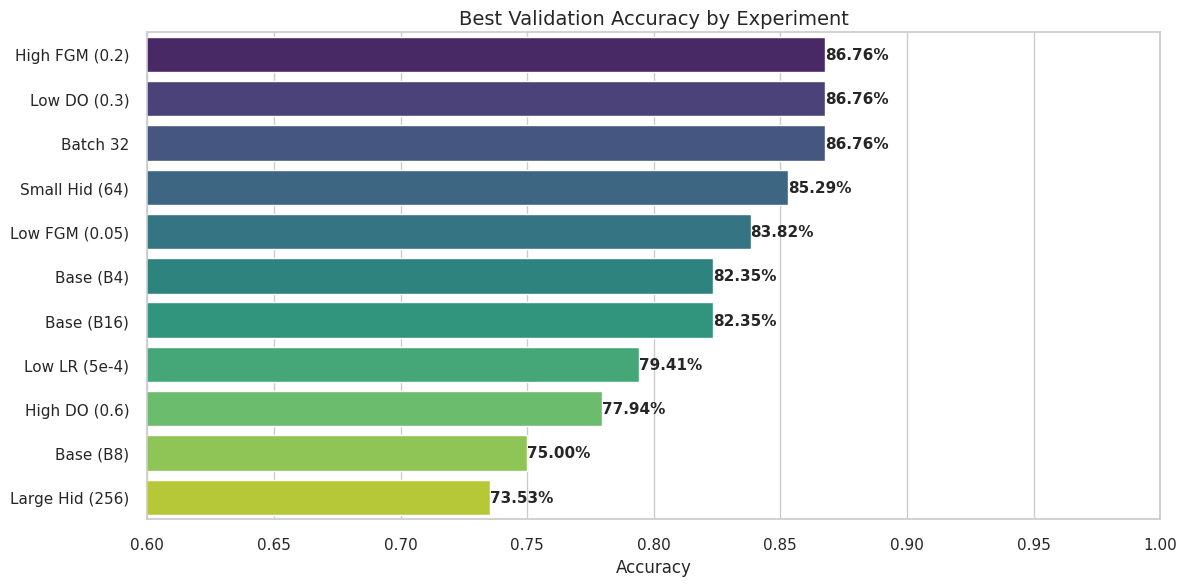

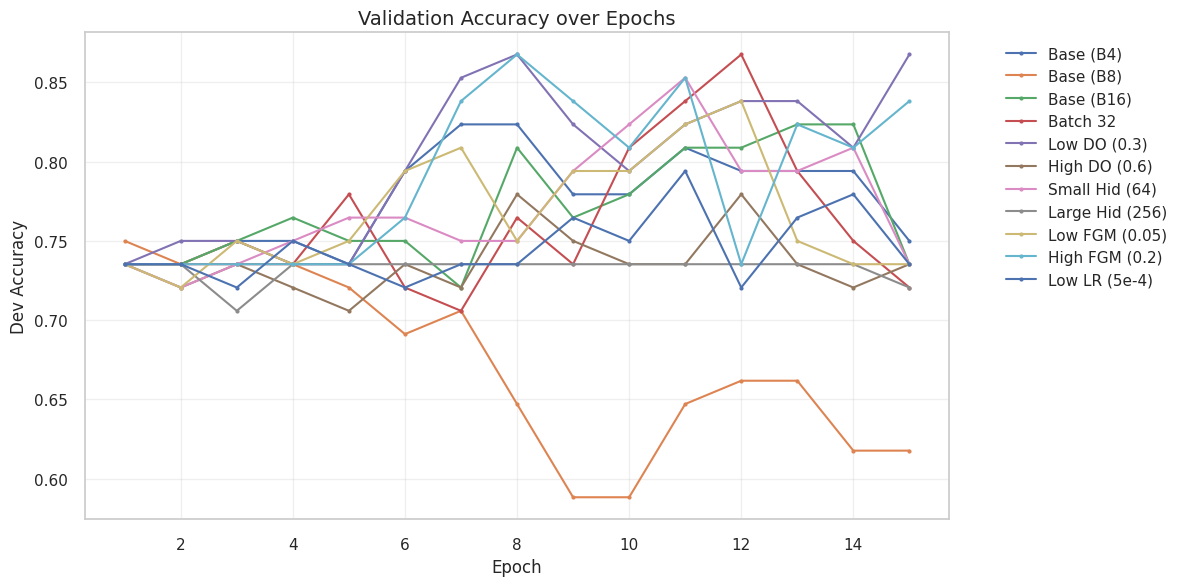

In [10]:
import sys
import os
import pickle
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# ==========================================
# 1. 환경 설정 및 라이브러리 로드
# ==========================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/DL_Project'
os.chdir(PROJECT_PATH)
sys.path.append(PROJECT_PATH)

try:
    from common.np import *
    from common.time_layers import TimeEmbedding, TimeLSTM, TimeDropout
    from common.layers import Affine, SoftmaxWithLoss, Sigmoid, Dropout
    from common.optimizer import Adam
    from utils import extract_utterances
    print("✅ 라이브러리 로드 성공.")
except ImportError as e:
    print(f"❌ 라이브러리 로드 실패: {e}")

# 시각화 스타일
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 11})

# ==========================================
# 2. 모델 및 유틸리티 클래스 정의
# ==========================================
# (필요한 클래스들: TimeBiLSTM, Attention, FGM, Model 등)
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1, Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        xs_reverse = xs[:, ::-1, :]
        o2 = self.backward_lstm.forward(xs_reverse)
        o2 = o2[:, ::-1, :]
        return np.concatenate((o1, o2), axis=2)

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1, do2 = dhs[:, :, :H], dhs[:, :, H:]
        dxs1 = self.forward_lstm.backward(do1)
        do2_reverse = do2[:, ::-1, :]
        dxs2 = self.backward_lstm.backward(do2_reverse)
        dxs2 = dxs2[:, ::-1, :]
        return dxs1 + dxs2

class Attention:
    def __init__(self):
        self.params, self.grads, self.cache = [], [], None
    def forward(self, hs, h):
        N, T, H = hs.shape
        hr = h.reshape(N, 1, H)
        t = np.sum(hs * hr, axis=2)
        t -= np.max(t, axis=1, keepdims=True)
        exp_t = np.exp(t)
        a = exp_t / np.sum(exp_t, axis=1, keepdims=True)
        ar = a.reshape(N, T, 1)
        c = np.sum(hs * ar, axis=1)
        self.cache = (hs, hr, a)
        return c
    def backward(self, dc):
        hs, hr, a = self.cache
        N, T, H = hs.shape
        ar = a.reshape(N, T, 1)
        d_hs = dc.reshape(N, 1, H) * ar
        da = np.sum(dc.reshape(N, 1, H) * hs, axis=2)
        dt = a * (da - np.sum(da * a, axis=1, keepdims=True))
        d_hs += dt.reshape(N, T, 1) * hr
        d_hr = np.sum(dt.reshape(N, T, 1) * hs, axis=1)
        dh = d_hr.reshape(N, H)
        return d_hs, dh

class FGM_Numpy:
    def __init__(self, model):
        self.model, self.backup = model, {}
    def attack(self, epsilon=1.0, emb_layer_name='embed'):
        emb_layer = getattr(self.model, emb_layer_name, None)
        if emb_layer:
            W, dW = emb_layer.params[0], emb_layer.grads[0]
            self.backup['W'] = W.copy()
            norm = np.sqrt(np.sum(dW**2))
            if norm != 0: W += epsilon * dW / norm
    def restore(self, emb_layer_name='embed'):
        emb_layer = getattr(self.model, emb_layer_name, None)
        if emb_layer and 'W' in self.backup:
            emb_layer.params[0][...] = self.backup['W']
        self.backup = {}

class BiAttentionMLPClassifier:
    def __init__(self, vocab_size, wordvec_size, hidden_size, class_size=2, dropout_ratio=0.5):
        V, D, H, C = vocab_size, wordvec_size, hidden_size, class_size
        rn = np.random.randn
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1, lstm_Wh1, lstm_b1 = (rn(D, 4*H)/np.sqrt(D)).astype('f'), (rn(H, 4*H)/np.sqrt(H)).astype('f'), np.zeros(4*H).astype('f')
        lstm_Wx2, lstm_Wh2, lstm_b2 = (rn(D, 4*H)/np.sqrt(D)).astype('f'), (rn(H, 4*H)/np.sqrt(H)).astype('f'), np.zeros(4*H).astype('f')
        input_size = 4 * H
        W1, b1 = (rn(input_size, H)/np.sqrt(input_size)).astype('f'), np.zeros(H).astype('f')
        W2, b2 = (rn(H, C)/np.sqrt(H)).astype('f'), np.zeros(C).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeBiLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, lstm_Wx2, lstm_Wh2, lstm_b2)
        self.attention = Attention()
        self.dropout1 = TimeDropout(dropout_ratio)
        self.affine1, self.activation = Affine(W1, b1), Sigmoid()
        self.dropout2, self.affine2 = Dropout(dropout_ratio), Affine(W2, b2)
        self.loss_layer = SoftmaxWithLoss()

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine1, self.affine2):
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        hs = self.dropout1.forward(hs)
        h_last = hs[:, -1, :]
        c = self.attention.forward(hs, h_last)
        out = np.concatenate((c, h_last), axis=1)
        out = self.affine1.forward(out)
        out = self.activation.forward(out)
        out = self.dropout2.forward(out)
        return self.affine2.forward(out)

    def forward(self, xs, ts):
        score = self.predict(xs)
        return self.loss_layer.forward(score, ts)

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine2.backward(dout)
        dout = self.dropout2.backward(dout)
        dout = self.activation.backward(dout)
        dout = self.affine1.backward(dout)
        N, H4 = dout.shape
        H2 = H4 // 2
        dc, dh_last = dout[:, :H2], dout[:, H2:]
        d_hs_att, dh_att = self.attention.backward(dc)
        dhs = d_hs_att
        dhs[:, -1, :] += (dh_last + dh_att)
        dhs = self.dropout1.backward(dhs)
        dhs = self.lstm.backward(dhs)
        self.embed.backward(dhs)

    def set_train_flg(self, train_flg=True):
        self.dropout1.train_flg = train_flg
        self.dropout2.train_flg = train_flg

# ==========================================
# 3. 데이터 로드
# ==========================================
def load_vocab(train_csv, max_vocab=4000):
    df = pd.read_csv(train_csv)
    words = []
    for _, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            text = " ".join([u.clean_text for u in utts]).lower()
            words.extend(text.split())
        except: continue
    counter = Counter(words)
    most_common = counter.most_common(max_vocab)
    vocab = {'<pad>': 0, '<unk>': 1}
    for i, (w, _) in enumerate(most_common): vocab[w] = i + 2
    return vocab

def load_data(csv_path, vocab, max_len=400):
    df = pd.read_csv(csv_path)
    x, t, label_map = [], [], {'TD': 0, 'SLI': 1}
    for _, row in df.iterrows():
        try:
            utts = extract_utterances(row['filename'], ['CHI'])
            if not utts: continue
            text = " ".join([u.clean_text for u in utts]).lower()
            tokens = text.split()
            ids = [vocab.get(w, vocab['<unk>']) for w in tokens]
            if len(ids) > max_len: ids = ids[:max_len]
            padded_ids = np.zeros(max_len, dtype=int)
            length = min(len(ids), max_len)
            padded_ids[:length] = ids[:length]
            x.append(padded_ids)
            t.append(label_map[row['group']])
        except: pass
    return np.array(x), np.array(t)

vocab = load_vocab('split/gillam_train.csv')
x_train, t_train = load_data('split/gillam_train.csv', vocab)
x_dev, t_dev = load_data('split/gillam_dev.csv', vocab)
if np.__name__ == 'cupy':
    x_train, t_train = np.asarray(x_train), np.asarray(t_train)
    x_dev, t_dev = np.asarray(x_dev), np.asarray(t_dev)

# ==========================================
# 4. 하이퍼파라미터 튜닝 정의 (배치 사이즈 포함)
# ==========================================
# 실험할 조합 리스트
search_space = [
    {'id': 'Base (B4)', 'dropout': 0.5, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 4},
    {'id': 'Base (B8)', 'dropout': 0.5, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 8},
    # 1. Base Settings (Batch 16)
    {'id': 'Base (B16)', 'dropout': 0.5, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 16},

    # 2. Batch Size Effect
    {'id': 'Batch 32',   'dropout': 0.5, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 32},

    # 3. Dropout Variants
    {'id': 'Low DO (0.3)',  'dropout': 0.3, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 16},
    {'id': 'High DO (0.6)', 'dropout': 0.6, 'hidden': 128, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 16},

    # 4. Hidden Size Variants
    {'id': 'Small Hid (64)',  'dropout': 0.5, 'hidden': 64,  'fgm': 0.1, 'lr': 0.001, 'batch_size': 16},
    {'id': 'Large Hid (256)', 'dropout': 0.5, 'hidden': 256, 'fgm': 0.1, 'lr': 0.001, 'batch_size': 16},

    # 5. FGM Variants
    {'id': 'Low FGM (0.05)',  'dropout': 0.5, 'hidden': 128, 'fgm': 0.05, 'lr': 0.001, 'batch_size': 16},
    {'id': 'High FGM (0.2)',  'dropout': 0.5, 'hidden': 128, 'fgm': 0.2,  'lr': 0.001, 'batch_size': 16},

    # 6. Learning Rate Variants
    {'id': 'Low LR (5e-4)',   'dropout': 0.5, 'hidden': 128, 'fgm': 0.1,  'lr': 0.0005, 'batch_size': 16},
]

# 결과 저장용
tuning_summary = []
tuning_history = {}
global_best_acc = 0.0
best_config = None

save_dir = 'tuning_results_batch'
if not os.path.exists(save_dir): os.makedirs(save_dir)

print(f"🔍 총 {len(search_space)}개 실험 시작...\n")

# ==========================================
# 5. 실험 루프 (Tuning Loop)
# ==========================================
for i, config in enumerate(search_space):
    exp_name = config['id']
    print(f"▶ [{exp_name}] Start: {config}")

    # 모델 초기화
    model = BiAttentionMLPClassifier(
        len(vocab), 100, config['hidden'], dropout_ratio=config['dropout']
    )
    optimizer = Adam(lr=config['lr'])
    fgm = FGM_Numpy(model)

    current_best = 0.0
    acc_history = []

    # 실험당 15 Epoch 실행
    for epoch in range(15):
        model.set_train_flg(True)
        idx = np.random.permutation(len(x_train))
        x_train_s = x_train[idx]
        t_train_s = t_train[idx]

        batch_size = config['batch_size']
        max_iters = len(x_train) // batch_size

        for j in range(max_iters):
            bx = x_train_s[j*batch_size : (j+1)*batch_size]
            bt = t_train_s[j*batch_size : (j+1)*batch_size]

            # Clean
            loss = model.forward(bx, bt)
            model.backward()

            # FGM
            fgm.attack(epsilon=config['fgm'])
            loss_adv = model.forward(bx, bt)
            model.backward()
            fgm.restore()

            optimizer.update(model.params, model.grads)

        # Eval
        model.set_train_flg(False)
        score = model.predict(x_dev)
        acc = np.sum(np.argmax(score, axis=1) == t_dev) / len(t_dev)
        acc_history.append(acc)

        if acc > current_best:
            current_best = acc

    print(f"   ✅ Best Dev Acc: {current_best*100:.2f}%")

    # 결과 기록
    res = config.copy()
    res['Best_Dev_Acc'] = current_best
    tuning_summary.append(res)
    tuning_history[exp_name] = acc_history

    if current_best > global_best_acc:
        global_best_acc = current_best
        best_config = config
        with open(f'{save_dir}/best_model_tuned.pkl', 'wb') as f:
            pickle.dump(model.params, f)

print(f"\n🏆 Overall Best: {global_best_acc*100:.2f}% ({best_config['id']})")

# ==========================================
# 6. 결과 시각화
# ==========================================
df_results = pd.DataFrame(tuning_summary)
df_results = df_results.sort_values(by='Best_Dev_Acc', ascending=False)
df_results.to_csv(f'{save_dir}/summary_table.csv', index=False)

print("\n📊 [실험 결과 요약]")
print(df_results[['id', 'Best_Dev_Acc', 'batch_size', 'dropout', 'hidden', 'fgm']])

# 1. Bar Chart (Best Acc Comparison)
plt.figure(figsize=(12, 6))
sns.barplot(x='Best_Dev_Acc', y='id', data=df_results, palette='viridis')
plt.title('Best Validation Accuracy by Experiment', fontsize=14)
plt.xlabel('Accuracy')
plt.ylabel('')
plt.xlim(0.6, 1.0)
for index, value in enumerate(df_results['Best_Dev_Acc']):
    plt.text(value, index, f'{value*100:.2f}%', va='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{save_dir}/chart_bar.png')
plt.show()

# 2. Line Chart (Learning Curves)
plt.figure(figsize=(12, 6))
for name, hist in tuning_history.items():
    plt.plot(range(1, 16), hist, marker='.', label=name)
plt.title('Validation Accuracy over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Dev Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{save_dir}/chart_lines.png')
plt.show()

🌟 [Best Configuration Found]
   ID: High FGM (0.2)
   Dev Accuracy: 86.76%
   Params: Hidden=128, Dropout=0.5, FGM=0.2

🔄 Loading Best Model Weights...
✅ 모델 준비 완료!

🚀 FINAL TEST ACCURACY: 72.06%
   (Correct: 49 / Total: 68)

📊 오답 상세 분석 중...

[오답 목록 - 총 19개]


,Index,File,Gender,Age,True,Pred,Length
0,0,55694il-l.cha,f,5,SLI,TD,160
1,1,a-1-68.cha,f,6,SLI,TD,136
2,2,a-2-33.cha,m,6,SLI,TD,212
3,3,a-2-67.cha,m,6,SLI,TD,205
4,4,a-3-29.cha,m,6,SLI,TD,143
5,5,46760nj-l.cha,m,7,SLI,TD,321
6,6,55695il-l.cha,m,7,SLI,TD,175
7,7,a-2-01.cha,m,7,SLI,TD,37
8,8,a-2-56.cha,m,7,SLI,TD,207
9,9,a-2-64.cha,m,7,SLI,TD,249


/tmp/ipython-input-1976650489.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_errors, x='Gender', ax=axes[0], palette='pastel')
/tmp/ipython-input-1976650489.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_errors, x='Age', ax=axes[1], palette='viridis')


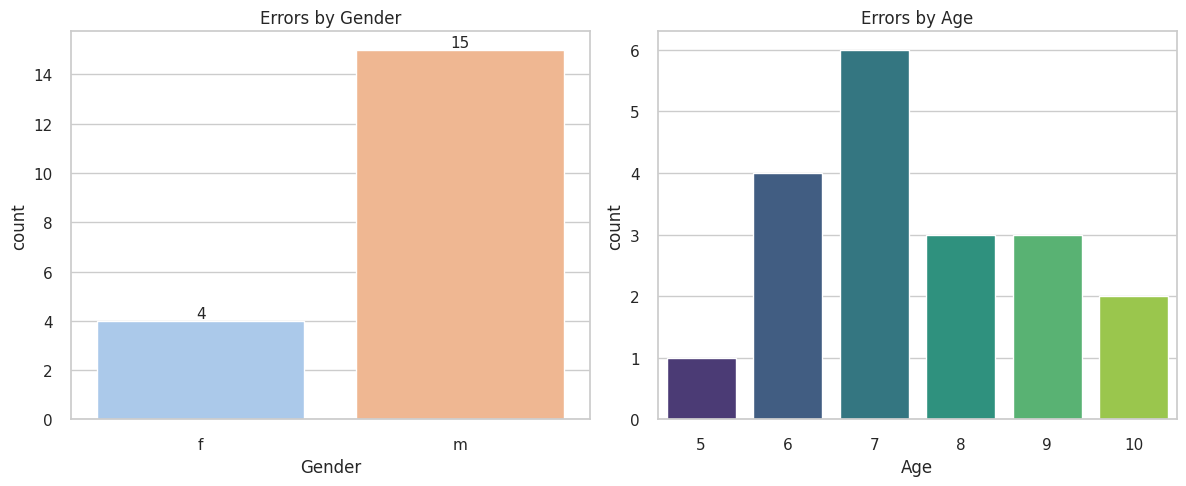


📝 [분석 코멘트]
- 성별 오답: 남(m) 15명, 여(f) 4명
- 평균 오답 문장 길이: 244.8 단어


In [11]:
import pandas as pd
import pickle
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. 최고 성능 설정(Best Config) 불러오기
# ==========================================
save_dir = 'tuning_results_batch'  # 방금 튜닝 결과가 저장된 폴더
csv_path = f'{save_dir}/summary_table.csv'
model_path = f'{save_dir}/best_model_tuned.pkl'

if os.path.exists(csv_path) and os.path.exists(model_path):
    # 결과 표 읽기
    df_results = pd.read_csv(csv_path)

    # Dev Acc가 가장 높은 설정 가져오기
    best_row = df_results.iloc[0] # 이미 정렬되어 저장됨
    print(f"🌟 [Best Configuration Found]")
    print(f"   ID: {best_row['id']}")
    print(f"   Dev Accuracy: {best_row['Best_Dev_Acc']*100:.2f}%")
    print(f"   Params: Hidden={int(best_row['hidden'])}, Dropout={best_row['dropout']}, FGM={best_row['fgm']}")

    # ==========================================
    # 2. 최적 모델 재구성 및 파라미터 로드
    # ==========================================
    # 저장된 설정대로 모델 생성
    best_model = BiAttentionMLPClassifier(
        vocab_size=len(vocab),
        wordvec_size=100,
        hidden_size=int(best_row['hidden']),
        dropout_ratio=best_row['dropout']
    )

    # 저장된 가중치(Weights) 로드
    print("\n🔄 Loading Best Model Weights...")
    with open(model_path, 'rb') as f:
        best_params = pickle.load(f)

    # 파라미터 덮어쓰기
    for i, param in enumerate(best_params):
        best_model.params[i][...] = param

    print("✅ 모델 준비 완료!")

    # ==========================================
    # 3. 최종 테스트 (Test Set Evaluation)
    # ==========================================
    best_model.set_train_flg(False)

    # Test 데이터 평가
    test_score = best_model.predict(x_test)
    test_pred = np.argmax(test_score, axis=1)

    # 정확도 계산
    correct = np.sum(test_pred == t_test)
    total = len(t_test)
    test_acc = correct / total

    print(f"\n" + "="*40)
    print(f"🚀 FINAL TEST ACCURACY: {test_acc*100:.2f}%")
    print(f"   (Correct: {correct} / Total: {total})")
    print(f"="*40)

    # ==========================================
    # 4. 상세 오답 분석 (Error Analysis)
    # ==========================================
    # 오답 데이터 추출
    test_df = pd.read_csv('split/gillam_test.csv')
    error_records = []

    # 라벨 매핑 (TD:0, SLI:1) -> 역매핑
    inv_label_map = {0: 'TD', 1: 'SLI'}

    print(f"\n📊 오답 상세 분석 중...")

    for idx, row in test_df.iterrows():
        # 예측값과 정답 비교 (이미 x_test 순서와 dataframe 순서는 동일하다고 가정)
        # 하지만 안전하게 인덱스로 접근
        if idx >= len(test_pred): break # 혹시 모를 인덱스 에러 방지

        p = test_pred[idx]
        t = t_test[idx] # t_test는 정수 라벨

        if p != t:
            # 텍스트 길이 등 메타데이터 가져오기
            try:
                utts = extract_utterances(row['filename'], ['CHI'])
                text_len = len(" ".join([u.clean_text for u in utts]).split())
            except: text_len = 0

            error_records.append({
                'Index': idx,
                'File': row['filename'].split('/')[-1],
                'Gender': row['gender'],
                'Age': row['age'],
                'True': inv_label_map[t],
                'Pred': inv_label_map[p],
                'Length': text_len
            })

    df_errors = pd.DataFrame(error_records)

    if not df_errors.empty:
        print(f"\n[오답 목록 - 총 {len(df_errors)}개]")
        display(df_errors) # 코랩에서는 표로 이쁘게 보임

        # 오답 통계 시각화
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # 성별 오답
        sns.countplot(data=df_errors, x='Gender', ax=axes[0], palette='pastel')
        axes[0].set_title('Errors by Gender')
        for p in axes[0].patches:
            axes[0].annotate(f'{int(p.get_height())}', (p.get_x()+0.4, p.get_height()), ha='center', va='bottom')

        # 연령별 오답
        sns.countplot(data=df_errors, x='Age', ax=axes[1], palette='viridis')
        axes[1].set_title('Errors by Age')

        plt.tight_layout()
        plt.show()

        print("\n📝 [분석 코멘트]")
        print(f"- 성별 오답: 남(m) {len(df_errors[df_errors['Gender']=='m'])}명, 여(f) {len(df_errors[df_errors['Gender']=='f'])}명")
        print(f"- 평균 오답 문장 길이: {df_errors['Length'].mean():.1f} 단어")

    else:
        print("🎉 축하합니다! 테스트 셋을 모두 맞췄습니다! (오답 0개)")

else:
    print("❌ 튜닝 결과 파일이 없습니다. 위 튜닝 코드를 먼저 실행해주세요.")

In [12]:
import os
from utils import extract_utterances, count_utterance_by_speaker

# 파일 경로 설정 (본인의 실제 경로로 수정 필요)
# 예: split/gillam_test.csv에서 확인한 경로
file_path = 'gillam/SLI/10m/55646co-l.cha'

# 절대 경로가 필요할 경우 수정 (예: Colab)
# file_path = '/content/drive/MyDrive/DL_Project/' + file_path

if os.path.exists(file_path):
    print(f"📄 파일 발견: {file_path}")

    # 1. 화자 분포 확인
    speakers = count_utterance_by_speaker(file_path)
    print(f"👥 화자별 발화 수: {speakers}")

    # 2. 아동(CHI) 발화 내용 확인
    target_speaker = ['CHI']
    utts = extract_utterances(file_path, target_speaker)

    print(f"\n🗣️ [CHI] 발화 내용 (총 {len(utts)}개):")
    for i, u in enumerate(utts):
        print(f"{i+1}. {u.clean_text}")
else:
    print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
    print("경로를 다시 확인해주세요.")

📄 파일 발견: gillam/SLI/10m/55646co-l.cha
👥 화자별 발화 수: {'CHI': 42, 'INV': 16}

🗣️ [CHI] 발화 내용 (총 42개):
1. -um the mom asked where do you guys wanna go ?
2. and they both named Mcdonalds .
3. so the mom took them there .
4. and Lisa couldn eh know who what she wanted a Big_Mac or a other little hamburger .
5. and the boy he he picked hamburger french fries and a milkshake chocolate one .
6. and the mom ordered -um hamburger pop and french fries .
7. and the girl Lisa ordered french fries pop hamburger and milkshake .
8. um um what's that one kind I call said ?
9. I don't either .
10. then he the guy said it would be twelve ninety nine .
11. and the mom could reached down .
12. and her purse wasn't there .
13. instead she remembered where she put it .
14. it was on at home on the her desk .
15. counter I mean counter .
16. what's his name though ?
17. a boy woke up .
18. and out of bed .
19. and hid his clock no he looked at his clock .
20. and it was -um late .
21. so yeah some cereal .
22. 